,close,z_close,zp_data,zp_data_standard,position
index,,,,,
2023-08-29 07:34:00,95.650,-0.044775,-1.749146,-0.322179,0
2023-08-29 07:36:00,95.650,-0.053422,-2.016672,-0.371455,0
2023-08-29 07:39:00,95.645,-0.362940,-2.299215,-0.423497,0
2023-08-29 07:47:00,95.645,-0.372111,-2.279558,-0.419876,0
2023-08-29 07:50:00,95.645,-0.378796,-2.256552,-0.415639,0
2023-08-29 07:56:00,95.635,-0.998138,-2.581729,-0.475534,1
2023-08-29 08:00:00,95.635,-0.998138,-2.561775,-0.471858,1
2023-08-29 08:02:00,95.630,-1.300984,-2.846778,-0.524354,1
2023-08-29 08:03:00,95.635,-0.994470,-2.784995,-0.512974,1


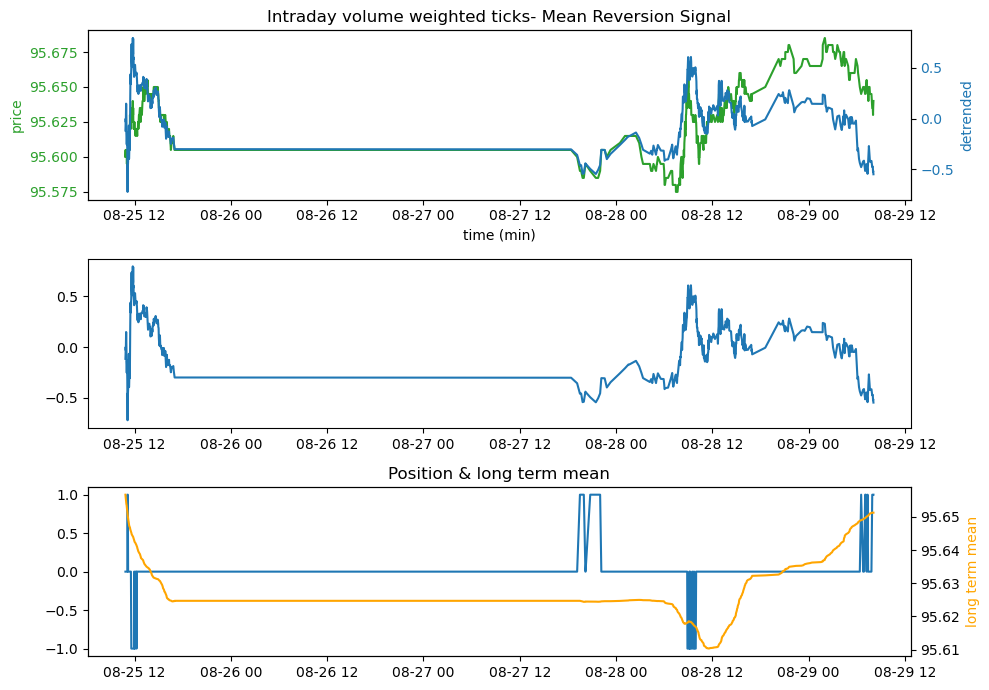

In [27]:
#test for dollar bars later
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
tickers = ['SFRZ4 Comdty']


#last 10 business days of intraday data
df = pd.DataFrame()

for ticker in tickers:
    for i in range(0,2*10):
        #print(i)
        today = datetime.datetime.today()
        date = today - BDay(i)
        #print(date)


        #lets do outright futures, swap spreads and future spreads
        fut = blp.bdib(ticker=ticker, dt= date , ref='CME', interval=1)
        if fut.columns.nlevels > 1:
            fut.columns = fut.columns.droplevel(0)
        df = df.append(fut)

    df['ticker']= ticker
    df['date']=df.index.strftime("%m/%d/%Y")
    df['time']= df.index.strftime("%H:%M:%S")
    df.sort_index(ascending=True, inplace = True)
    df.index = df.index.tz_localize(None)

    
trades = df[['close','volume']].copy()
trades.reset_index(inplace= True)
trades['index']=pd.to_numeric(trades['index'])#trades['index'].astype(str)

def calculateMaxDD(cumret):
# =============================================================================
# calculation of maximum drawdown and maximum drawdown duration based on
# cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
# i is the index of the day with maxDD.
# =============================================================================
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
             
    maxDD, i=np.min(drawdown), np.argmin(drawdown) # drawdown < 0 always
    maxDDD=np.max(drawdownduration)
    return maxDD, maxDDD, i


#generate volume bars we only fill a new bar if a set number of futures are traded. 
#This will remove a lot of the asia session futures with low liquitiy
def generate_volumebars(trades, frequency=10):
    times = trades[:,0]
    prices = trades[:,1]
    volumes = trades[:,2]
    ans = np.zeros(shape=(len(prices), 6))
    candle_counter = 0
    vol = 0
    lasti = 0
    for i in range(len(prices)):
        vol += volumes[i]
        if vol >= frequency:
            #print(times[i] )
            #print(ans[candle_counter][0])
            ans[candle_counter][0] = times[i]             # time
            ans[candle_counter][1] = prices[lasti]                     # open
            ans[candle_counter][2] = np.max(prices[lasti:i+1])         # high
            ans[candle_counter][3] = np.min(prices[lasti:i+1])         # low
            ans[candle_counter][4] = prices[i]                         # close
            ans[candle_counter][5] = np.sum(volumes[lasti:i+1])        # volume
            candle_counter += 1
            lasti = i+1
            vol = 0
    return ans[:candle_counter]

#determine trading volume threshold
#lets just use average for now.
#going fwd we can do a 20 day moving average sampled about 50 times a day
threshold = round(trades['volume'].mean(),0)

volume_trades =generate_volumebars(trades.to_numpy(), frequency =threshold)

volume_trades = pd.DataFrame(volume_trades, columns =['index','open','high','low','close','volume'])
volume_trades.set_index('index', inplace = True)

trades.set_index('index', inplace = True)
#convert back to datetime
volume_trades.index = pd.to_datetime(volume_trades.index.astype(np.int64), format ='%Y-%m-%d %H:%M:%S')
trades.index = pd.to_datetime(trades.index, format ='%Y-%m-%d %H:%M:%S')
df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=180).mean()) / df['close'].rolling(window=180).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)
df.dropna(inplace = True)
scaler = MaxAbsScaler()
standard = scaler.fit_transform(df[['zp_data']])
df['zp_data_standard'] = standard


fig = plt.figure(figsize=(10, 7))
fig.add_subplot(311)   #first is number of rows, second is number of columns
fig.add_subplot(312)   
fig.add_subplot(313)   
# create all axes we need
ax0 = plt.subplot(311) #first is number of rows, second is number of columns
ax1 = ax0.twinx()
ax2 = plt.subplot(312)

ax1.set_title('Intraday volume weighted ticks- Mean Reversion Signal')
ax2.set_title('normalized Signal')
#signal plot
color = 'tab:green'
ax0.set_xlabel('time (min)')
ax0.set_ylabel('price', color=color)
ax0.plot(df['close'].tail(500).index, df['close'].tail(500), color=color)
ax0.tick_params(axis='y', labelcolor=color)
#position
df['position']= df['zp_data_standard'].apply(lambda x: -1 if x>0.45 else (1 if x<-0.45 else 0))


#ax4 = plt.subplot(313)
#price plot
color = 'tab:blue'
ax1.set_ylabel('detrended', color=color)  # we already handled the x-label with ax1
ax1.plot(df['zp_data_standard'].tail(500).index, df['zp_data_standard'].tail(500), color=color)
#ax1.plot(df['position'].tail(500).index, df['position'].tail(500), color='orange')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = plt.subplot(312)
ax2.plot(df['zp_data_standard'].tail(500).index, df['zp_data_standard'].tail(500), color=color)


ax3 = plt.subplot(313)
ax4 = ax3.twinx()
ax3.set_title('Position & long term mean')
ax3.plot(df['position'].tail(500).index, df['position'].tail(500), color=color)
ax4.plot( df.tail(500).index, df['close'].rolling(window=180).mean().tail(500), color='orange')
ax4.set_ylabel('long term mean', color='orange') 
#ax3.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
df.tail(10)



<AxesSubplot:xlabel='index'>

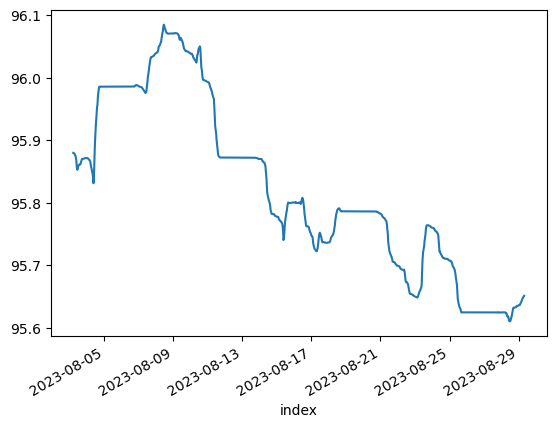

In [18]:
df['close'].rolling(window=180).mean().plot()

In [34]:
df['close'].std()*3  4 bps stop loss

0.4124578313199746

In [96]:
df.to_csv('entry_analysis.csv')

(array([  35.,  193.,  514.,  846., 1196., 1214., 1023.,  639.,  196.,
          38.]),
 array([-1.        , -0.80354922, -0.60709843, -0.41064765, -0.21419686,
        -0.01774608,  0.1787047 ,  0.37515549,  0.57160627,  0.76805706,
         0.96450784]),
 <BarContainer object of 10 artists>)

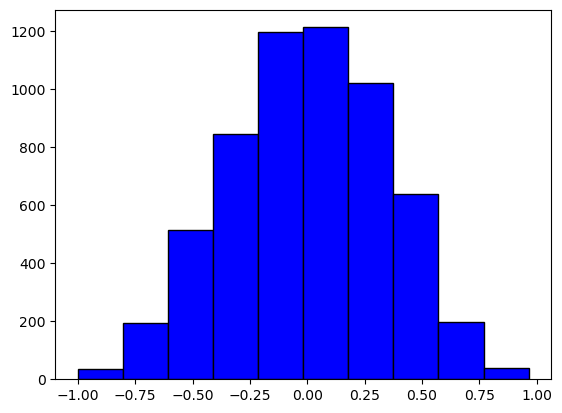

In [91]:
plt.hist(df['zp_data_standard'] , color = 'blue', edgecolor = 'black')

In [11]:
df[(df['position']!=0)].tail(10)

,close,z_close,zp_data,zp_data_standard,position
index,,,,,
2023-08-27 19:39:00,95.590,-2.908916,-4.296392,-0.767103,1
2023-08-27 19:50:00,95.585,-3.109313,-4.486234,-0.800999,1
2023-08-27 19:59:00,95.585,-2.971781,-2.893753,-0.516668,1
2023-08-27 20:11:00,95.595,-2.270344,-2.696570,-0.481462,1
2023-08-27 20:12:00,95.595,-2.214408,-3.614809,-0.645410,1
2023-08-27 20:47:00,95.590,-2.455233,-3.348704,-0.597898,1
2023-08-27 21:46:00,95.585,-2.572473,-3.932552,-0.702141,1
2023-08-27 22:01:00,95.590,-2.227726,-3.085541,-0.550911,1
2023-08-27 22:35:00,95.605,-1.360977,-2.681199,-0.478717,1


<AxesSubplot:xlabel='index'>

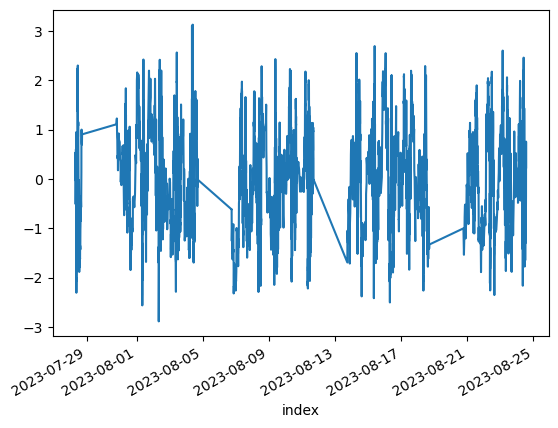

In [135]:
df['zp_data_standard'].plot()

In [223]:
df

,close
index,
2023-02-07 18:40:00,95.250
2023-02-07 19:27:00,95.265
2023-02-07 19:56:00,95.270
2023-02-07 20:14:00,95.275
2023-02-07 20:19:00,95.275
...,...
2023-08-23 15:23:00,94.595
2023-08-23 15:26:00,94.595
2023-08-23 15:31:00,94.595


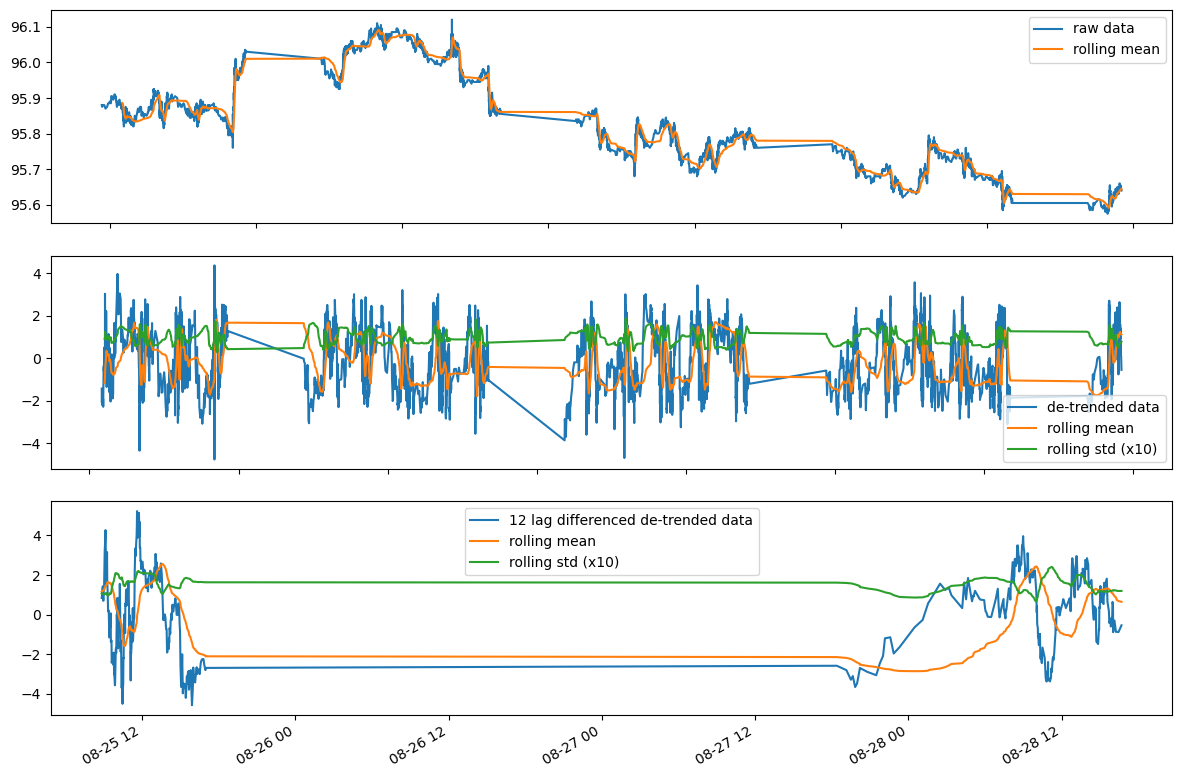

In [87]:
df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=60).mean()) / df['close'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)


def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['close'], label='raw data')
    ax[0].plot(df['close'].rolling(window=60).mean(), label="rolling mean");
    #ax[0].plot(df['open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_close'], label="de-trended data")
    ax[1].plot(df['z_close'].rolling(window=60).mean(), label="rolling mean");
    ax[1].plot(df['z_close'].rolling(window=60).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.tail(500).index, df['zp_data'].tail(500), label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_data'].rolling(window=60).mean().tail(500), label="rolling mean");
    ax[2].plot(df['zp_data'].rolling(window=60).std().tail(500), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df)

In [224]:
df = volume_trades[['close']].copy()
df['z_close'] = (df['close'] - df['close'].rolling(window=60).mean()) / df['close'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_close'] - df['z_close'].shift(60)


In [233]:
df#['zp_data'].plot()

,close,z_close,zp_data
index,,,
2023-02-07 18:40:00,95.250,NaN,NaN
2023-02-07 19:27:00,95.265,NaN,NaN
2023-02-07 19:56:00,95.270,NaN,NaN
2023-02-07 20:14:00,95.275,NaN,NaN
2023-02-07 20:19:00,95.275,NaN,NaN
...,...,...,...
2023-08-23 15:23:00,94.595,-0.725081,-1.457749
2023-08-23 15:26:00,94.595,-0.703346,-1.411203
2023-08-23 15:31:00,94.595,-0.681991,-1.363635


In [212]:
def rolling_z_score(df, lookback_mu, lookback_sigma):
    mu = df.rolling(lookback_mu).mean()
    sigma = df.rolling(lookback_sigma).std()
    df['indicator'] = (df.copy() - mu) / sigma
    return df


def signal_rolling_z_meanreversion(df,lookback_mu, lookback_sigma, bound):
    
    signals=pd.DataFrame(rolling_z_score(df,lookback_mu, lookback_sigma))
    signals['positions']=0

    #increase position size relative to strength of indicator pass the 
    signals.loc[signals["indicator"] <= -bound , "positions"] = -signals["indicator"]-bound
    signals.loc[signals["indicator"] >= bound , "positions"] = -signals["indicator"]+bound
    #sizing determined by tanh function to set between -1 and 1, this stops us from overbetting/ setting bets with concurrent signals >1
    #signals["signals"]=np.tanh(signals["positions"])

    return signals
signal_df = signal_rolling_z_meanreversion(volume_trades[['close']], 600,600,2)

C:\Users\chengc3\AppData\Local\Temp\ipykernel_18924\2459001072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['indicator'] = (df.copy() - mu) / sigma


<AxesSubplot:xlabel='index'>

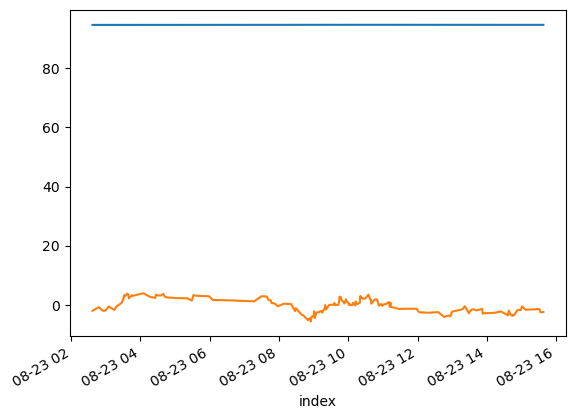

In [234]:
df['close'].tail(200).plot()
df['zp_data'].tail(200).plot()

In [217]:
#FOR TY FUTURES
def rolling_z_score(df, lookback_mu, lookback_sigma):
    mu = df.rolling(lookback_mu).mean()
    sigma = df.rolling(lookback_sigma).std()
    df['indicator'] = (df.copy() - mu) / sigma
    return df

def signal_rolling_z_meanreversion(df,lookback_mu, lookback_sigma, bound):
    
    signals=pd.DataFrame(rolling_z_score(df,lookback_mu, lookback_sigma))
    signals['positions']=0

    #increase position size relative to strength of indicator pass the 
    signals.loc[signals["indicator"] <= -bound , "positions"] = -signals["indicator"]-bound
    signals.loc[signals["indicator"] >= bound , "positions"] = -signals["indicator"]+bound
    #sizing determined by tanh function to set between -1 and 1, this stops us from overbetting/ setting bets with concurrent signals >1
    #ignals["signals"]=np.tanh(signals["positions"])

    return signals

import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
trade_long_list = []
trade_short_list =[]
mean_return_list = []
#results lists
results_lookback_list = []
results_hold_list = []
results_zscore_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []


zscore_entry_list =[]
lookback_list = []
holdtime_list = []

#lookback for z score
for p in range(20*60,(24*10*60)+1,24*60): #maybe reduce to 1 hour blocks
    lookback_list.append(p)    
lookback_list =[24*60*10]
#entry criteria for short MA/long MA ratio:

for p in range(20,35,5):
    #1.0005
    zscore_entry_list.append(p/10)
zscore_entry_list =[2]    
#different holdtimes
for p in range(180,600*10+1,60):
    holdtime_list.append(p)    
holdtime_list    

#holdtime_list=[60]
    
#try first for holdtime

for lookback in lookback_list:
    #generate the mean reversion zscore signal
    start_time = time.time()
    print(lookback)
    for bound in zscore_entry_list:
        df = signal_rolling_z_meanreversion(volume_trades[['close']], lookback,lookback,bound)
        
        #calculate augmented dickey Fuller 
        
        
        #calculate Hurst exponent
        
        
        
        #create table of longs and shorts
        longs= df['positions']>0
        shorts= df['positions'] <0
        
        for holdtime in holdtime_list:
            print(holdtime)
            pos=np.zeros(df[['close']].shape)
            
            for h in range(holdtime-1):
                # signal can double down
                
                long_lag=longs.copy().shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 
                
                short_lag=shorts.copy().shift(h).fillna(False)
                pos[long_lag]=pos[long_lag]+1
                pos[short_lag]=pos[short_lag]-1
                

            pos=pd.DataFrame(pos, index = longs.index)
            #to remove double downing effect
            #we set anything >1 or <-1 to be 1 and -1 respective.
            pos[pos[0]>1] = 1
            pos[pos[0]<-1] = -1
            pnl=np.sum((pos.shift().values)*(df[["close"]].pct_change()), axis=1) # daily P&L of the strategy
            ret=pnl#/np.sum(np.abs(pos.shift()), axis=1)
            #print(np.mean(ret))
            #print(np.std(ret))
            cumret=(np.cumprod(1+ret)-1)
            #print("---returns data %s seconds ---" % (time.time() - start_time))
            #start_time = time.time()
            sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
            #print("---sharpe data %s seconds ---" % (time.time() - start_time))
            #start_time = time.time()
            print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))

            maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
            #print("---maxdd data %s seconds ---" % (time.time() - start_time))
            print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
            results_lookback_list.append(lookback)
            results_hold_list.append(holdtime)
            results_zscore_trigger_list.append(bound)
            apr_list.append(np.prod(1+ret)**(252/len(ret))-1)
            sharpe_list.append(sharpe)
            dd_list.append(maxDD)
            dd_time_list.append(maxDDD)
            trade_long_list.append(len(pos[long_lag]>0))
            trade_short_list.append(len(pos[short_lag]>0))
            mean_return_list.append(np.mean(ret))
    print("---maxdd data %s seconds ---" % (time.time() - start_time))


14400
180


C:\Users\chengc3\AppData\Local\Temp\ipykernel_18924\2444853181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['indicator'] = (df.copy() - mu) / sigma


APR=0.000011 Sharpe=0.037568
Max DD=-0.004559 Max DDD in days=11693
240
APR=0.000012 Sharpe=0.038809
Max DD=-0.004716 Max DDD in days=11693
300
APR=0.000008 Sharpe=0.026092
Max DD=-0.005081 Max DDD in days=11561
360
APR=-0.000005 Sharpe=-0.015173
Max DD=-0.005394 Max DDD in days=18098
420
APR=-0.000013 Sharpe=-0.037112
Max DD=-0.005342 Max DDD in days=18098
480
APR=-0.000016 Sharpe=-0.043928
Max DD=-0.005603 Max DDD in days=18098
540
APR=-0.000019 Sharpe=-0.050029
Max DD=-0.005603 Max DDD in days=18098
600
APR=-0.000025 Sharpe=-0.066229
Max DD=-0.006337 Max DDD in days=18098
660
APR=-0.000026 Sharpe=-0.068431
Max DD=-0.006651 Max DDD in days=18098
720
APR=-0.000026 Sharpe=-0.069661
Max DD=-0.006756 Max DDD in days=18098
780
APR=-0.000022 Sharpe=-0.058250
Max DD=-0.006128 Max DDD in days=18098
840
APR=-0.000026 Sharpe=-0.067336
Max DD=-0.006703 Max DDD in days=18098
900
APR=-0.000027 Sharpe=-0.070850
Max DD=-0.006599 Max DDD in days=18098
960
APR=-0.000026 Sharpe=-0.068260
Max DD=-0.006

KeyboardInterrupt: 

In [140]:
holdtime_list

NameError: name 'holdtime_list' is not defined

<AxesSubplot:xlabel='index'>

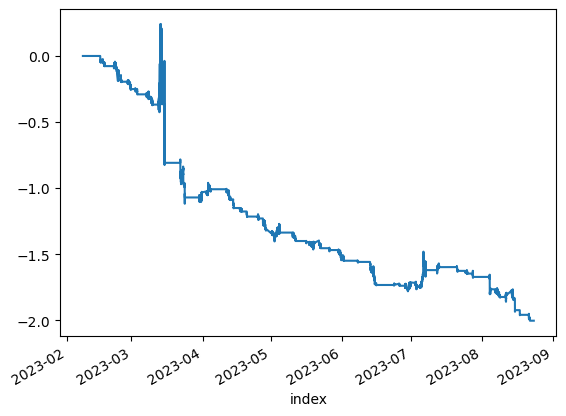

In [188]:
pnl.cumsum().plot()

<AxesSubplot:xlabel='index'>

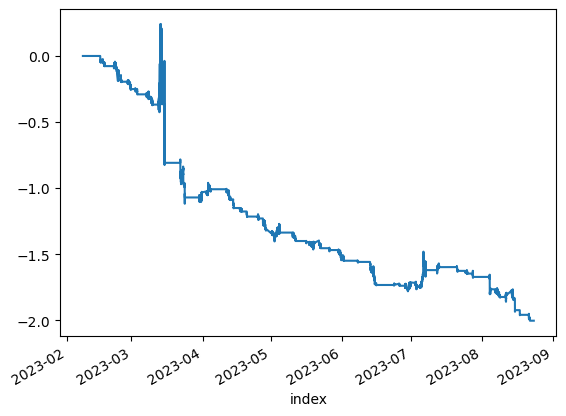

In [189]:
ret.cumsum().plot()

In [99]:
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['mean_return'] = mean_return_list
#df_results.to_csv('backtest_momo_intra_v4.csv')

3755

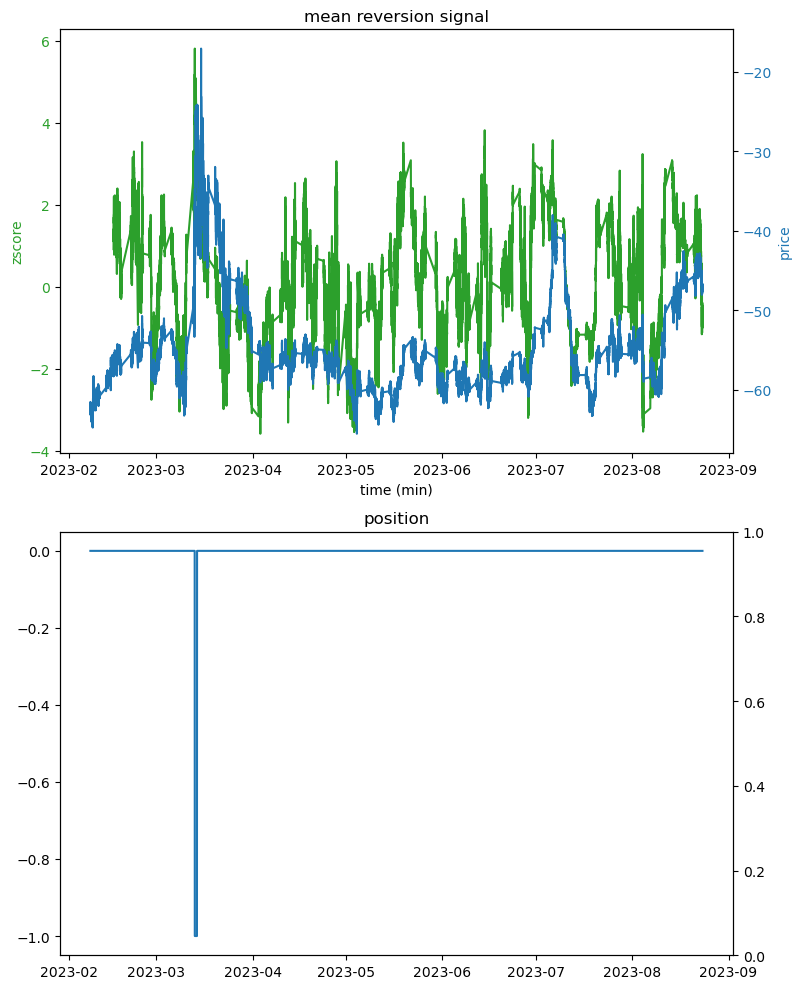

In [155]:
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(221)   #top left
#fig.add_subplot(222)   #top right
fig.add_subplot(223)   #bottom left
#fig.add_subplot(224)   #bottom right 
# create all axes we need
ax0 = plt.subplot(221)
ax1 = ax0.twinx()
ax2 = plt.subplot(223)
ax3 = ax2.twinx()
ax1.set_title('mean reversion signal')
ax2.set_title('position')
#signal plot
color = 'tab:green'
ax0.set_xlabel('time (min)')
ax0.set_ylabel('zscore', color=color)
ax0.plot(df['indicator'].index, df['indicator'], color=color)
ax0.tick_params(axis='y', labelcolor=color)

#price plot
color = 'tab:blue'
ax1.set_ylabel('price', color=color)  # we already handled the x-label with ax1
ax1.plot(df['close'].index, df['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

#signal plot
ax2.plot(pos.index, pos[0], color=color)

# share the secondary axes
ax3.get_shared_x_axes().join(ax1, ax3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

<AxesSubplot:xlabel='index'>

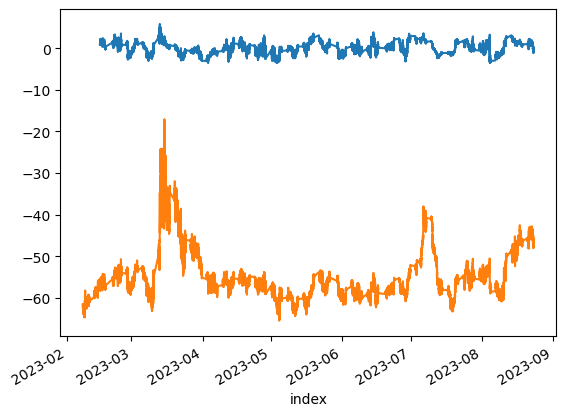

In [134]:
df['indicator'].plot()
df['close'].plot()

<AxesSubplot:xlabel='index'>

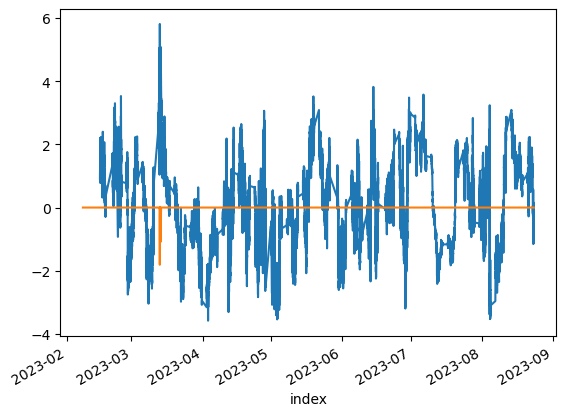

In [144]:
df['indicator'].plot()
df['positions'].plot()

<AxesSubplot:xlabel='index'>

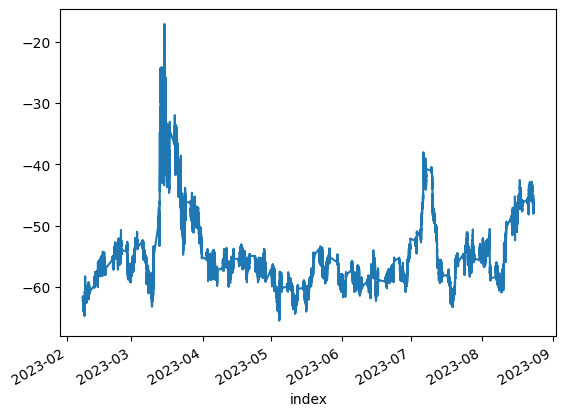

In [118]:
volume_trades['close'].plot()

<AxesSubplot:xlabel='index'>

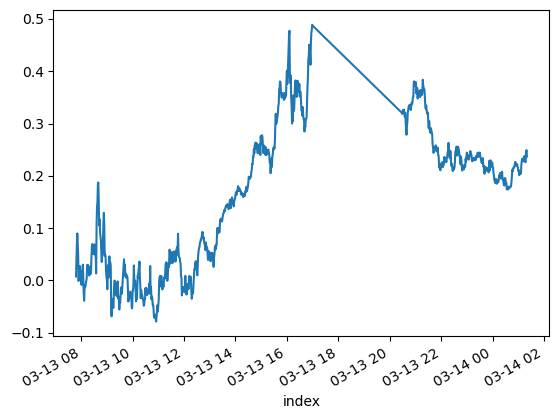

In [161]:
ret.cumsum().plot()#.plot()#[long_lag.index]

<AxesSubplot:xlabel='index'>

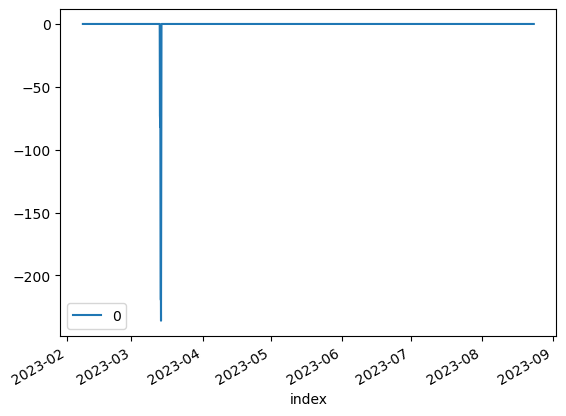

In [164]:
pos.plot()

In [77]:
for h in range(holdtime-1):
    # signal can double down

    long_lag=longs.copy().shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 

    short_lag=shorts.copy().shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [518]:
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
df_results['mean_return'] = mean_return_list
df_results.to_csv('backtest_momo_intra_480.csv')

In [475]:
for ma_tuples in short_long_tuples_list:
    #generate the crossover signal
    start_time = time.time()
    print(ma_tuples)
    df = volume_trades[['close']].copy()
    df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
    df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
    df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
    
    #criteria for position to be entered
    for ratio in ratio_entry_list:
        longs= df[['ewm_ratio']] > (1+ ratio)
        shorts=df[['ewm_ratio']] < (1-ratio)
        print("ratio_"+str(ratio))
        print("longslens_"+str(len(longs)))
        print("longsshorts_"+str(len(shorts)))

(30, 60)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 120)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 120)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 120)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 180)
ratio_0.000

ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
lon

ratio_0.0005
longslens_44902
longsshorts_44902
(240, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
lon

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 720)
ratio_0.0001
lon

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 840)
ratio_0.0001
lon

ratio_0.0005
longslens_44902
longsshorts_44902
(300, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
lon

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 1080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 1080)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(240, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 1320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 1320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1320)
ratio_0.0001

ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 1440)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 1560)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 1560)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 1560)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 1560)
ratio_0.0001
lo

ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 1620)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 1740)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 1740)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 1740)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 1740)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 1860)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 1860)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 1860)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 1860)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 1980)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 1980)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 1980)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 1980)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 2100)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 2100)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 2100)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 2100)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 2220)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 2220)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 2220)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 2220)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 2340)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 2340)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 2340)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 2340)
ratio_0.0001
l

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 2400)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 2400)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 2400)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 2460)
ratio_0.0001


ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 2520)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 2640)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 2640)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 2640)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 2640)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(240, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 2760)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(180, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 2880)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 2940)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 3000)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 3000)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 3000)
ratio_0.0001
lo

ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 3060)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 3180)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 3180)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(510, 3180)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 3180)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(330, 3300)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 3300)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 3300)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 3300)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(210, 3420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 3420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 3420)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 3420)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 3540)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 3540)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(120, 3540)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(150, 3540)
ratio_0.0001
l

ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 3600)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 3660)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(60, 3660)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(90, 3660)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
lo

ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 3720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 3720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 3720)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(30, 3780)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002


ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 3840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(660, 3840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(690, 3840)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(720, 3840)
ratio_0.0001

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(540, 3960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(570, 3960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(600, 3960)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(630, 3960)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(420, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(480, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(510, 4080)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(360, 4200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(390, 4200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(420, 4200)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(450, 4200)
ratio_0.0001

ratio_0.0005
longslens_44902
longsshorts_44902
(210, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(240, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(270, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005
longslens_44902
longsshorts_44902
(300, 4320)
ratio_0.0001
longslens_44902
longsshorts_44902
ratio_0.0002
longslens_44902
longsshorts_44902
ratio_0.0003
longslens_44902
longsshorts_44902
ratio_0.0004
longslens_44902
longsshorts_44902
ratio_0.0005

In [362]:
len(short_lag[short_lag['ewm_ratio']==True])

3

In [378]:
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list
#df_results.to_csv('intra_ma_momo.csv')
df_results

,short_long_ma,holdtime_mins,ratio,apr,sharpe,max_dd,max_dd_ticks,max_dd_days,long_trades_no,short_trades_no
0,"(30, 60)",5,0.0001,0.000016,0.268158,0,0,0.0,114,96
1,"(30, 60)",10,0.0001,0.000016,0.268158,0,0,0.0,114,96
2,"(30, 60)",20,0.0001,0.000016,0.268158,0,0,0.0,114,96
3,"(30, 60)",30,0.0001,0.000016,0.268158,0,0,0.0,114,96
4,"(30, 60)",120,0.0001,0.000016,0.268158,0,0,0.0,114,96
5,"(30, 60)",5,0.0002,0.000008,0.627500,0,0,0.0,19,11
6,"(30, 60)",10,0.0002,0.000008,0.627500,0,0,0.0,19,11


60
APR=0.000700 Sharpe=0.733223
Max DD=-0.116913 Max DDD in days=4270
12976 15848


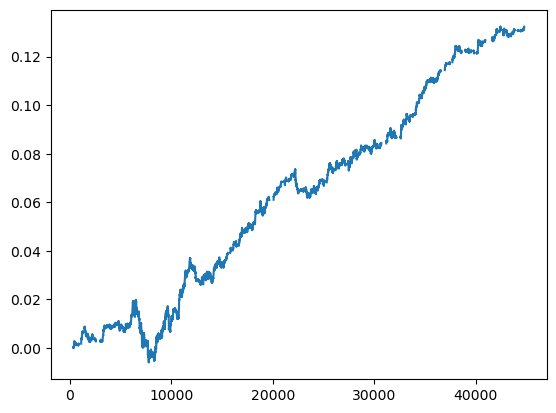

In [514]:
ma_tuples = (30,60)
holdtime=60

ratio = 0.0001

start_time 
df = volume_trades[['close']].copy()

print(holdtime)
df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
df['ewm_ratio'] = df['ewm_short']/df['ewm_long']

        
longs= df[['ewm_ratio']] > (1+ ratio)
shorts=df[['ewm_ratio']] < (1-ratio)

pos=np.zeros(df[['close']].shape)

for h in range(holdtime-1): # this prevents doubling down of signal 
    #(but will keep extending 1 bar if the signal remains strong) so no hard take profit!
    #moving stop loss ?
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()#marker='x')

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
print(len(pos[pos[0]>0]),len(pos[pos[0]<0]))

<AxesSubplot:xlabel='index'>

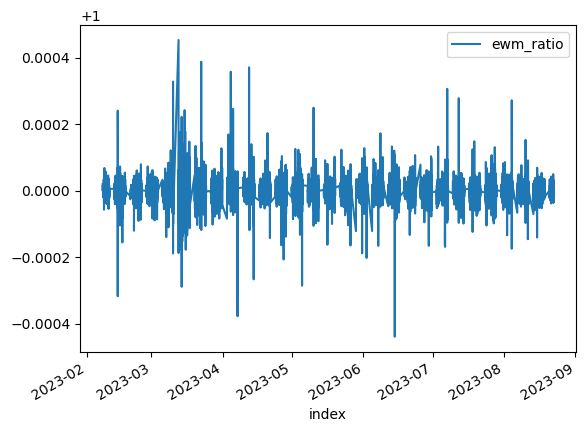

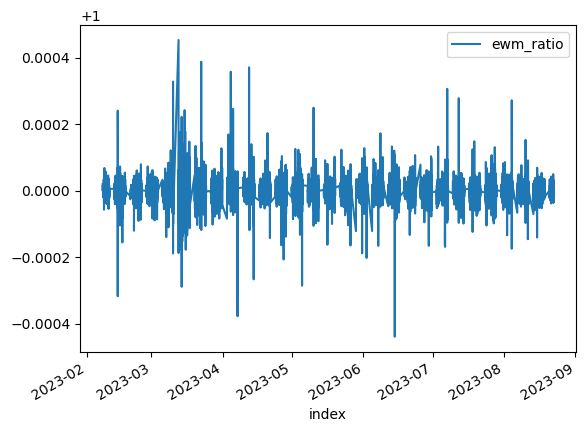

In [500]:
df[['ewm_ratio']].plot()

df_second[['ewm_ratio']].plot()

In [510]:
df[['ewm_long']]#.to_csv('ewm_')

,ewm_long
index,
2023-02-07 19:20:00,96.745000
2023-02-07 19:53:00,96.745000
2023-02-07 20:39:00,96.748445
2023-02-07 21:29:00,96.750167
2023-02-07 21:58:00,96.753334
...,...
2023-08-23 09:49:00,95.718208
2023-08-23 09:50:00,95.719906
2023-08-23 09:51:00,95.721548


In [509]:
df_second[['ewm_long']]#.plot()

,ewm_long
index,
2023-02-07 19:20:00,96.745000
2023-02-07 19:53:00,96.745000
2023-02-07 20:39:00,96.748370
2023-02-07 21:29:00,96.750056
2023-02-07 21:58:00,96.753111
...,...
2023-08-23 09:49:00,95.693301
2023-08-23 09:50:00,95.694148
2023-08-23 09:51:00,95.694986


<AxesSubplot:xlabel='index'>

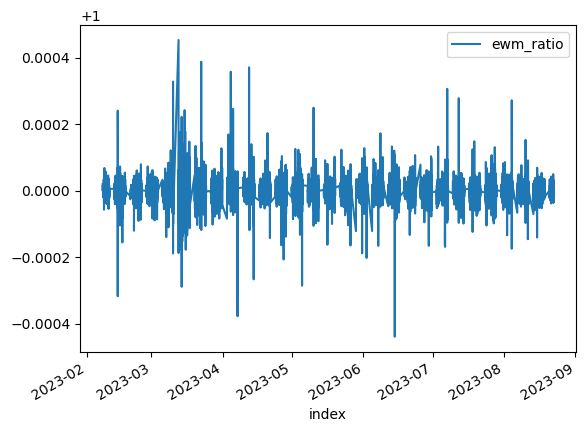

In [495]:
df[['ewm_ratio']].plot()

60
APR=0.000358 Sharpe=1.133711
Max DD=-0.063326 Max DDD in days=5443
3158 2655


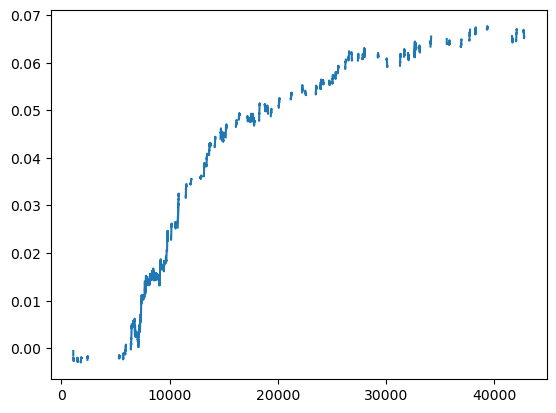

In [498]:
ma_tuples = (30,60)
holdtime=60

ratio = 0.0001

start_time 
df = volume_trades[['close']].copy()

print(holdtime)
df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
df_second = df.copy()
        
longs= df[['ewm_ratio']] > (1+ ratio)
shorts=df[['ewm_ratio']] < (1-ratio)

pos=np.zeros(df[['close']].shape)

for h in range(holdtime-1): # this prevents doubling down of signal 
    #(but will keep extending 1 bar if the signal remains strong) so no hard take profit!
    #moving stop loss ?
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot()#marker='x')

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
print(len(pos[pos[0]>0]),len(pos[pos[0]<0]))

In [483]:
pos[pos[0]<0]

,0
1097,-1.0
1098,-1.0
1159,-1.0
1160,-1.0
1161,-1.0
...,...
42742,-1.0
42743,-1.0
42744,-1.0
42745,-1.0


In [384]:
#FOR TY FUTURES
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
cc_results = []
pval_results =[]
lookback_list = []
holdtime_list = []
time_space_list =[]
ratio_entry_list = []
long_time_space_list = []
short_long_tuples_list = []
trade_long_list = []
trade_short_list =[]

#results lists
results_tuple_list = []
results_hold_list = []
results_ratio_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
#lookback periods for MA
#lookback short MA
for p in range(30,721,30):
    time_space_list.append(p)    
#lookback long MA
for p in range(60,24*60*3+1,60):
    long_time_space_list.append(p)   
#create tuples of lookback long MA and short MA
for i in long_time_space_list:
    for j in time_space_list:
        if j< i:
            short_long_tuples_list.append((j,i))
#entry criteria for short MA/long MA ratio:

for p in range(1,6,1):
    #1.0005
    ratio_entry_list.append(p/10000)
    
#different holdtimes
for p in range(60,601,60):
    holdtime_list.append(p)    
holdtime_list = [5,10,20,30,120]    
#so we can have exits based off holdtime
#or based off hitting upper bounds(?) of the short/long entries
    
#try first for holdtime

#short_long_tuples_list =[(60,720),(90,720)]
#holdtime_list = [360]
for ma_tuples in short_long_tuples_list:
    #generate the crossover signal
    start_time = time.time()
    print(ma_tuples)
    df = volume_trades[['close']].copy()
    df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
    df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
    df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
    
    #criteria for position to be entered
    for ratio in ratio_entry_list:
        print(ratio)
        longs= df[['ewm_ratio']] > (1+ ratio)
        shorts=df[['ewm_ratio']] < (1-ratio)

        pos=np.zeros(df[['close']].shape)
        for holdtime in holdtime_list:
        #pnl based off holdtime
            print(holdtime)
        #holddays=ma_tuples[1]
            for h in range(holdtime-1): # signal can double down (look into how we can change this)
                
                long_lag=longs.shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 
                short_lag=shorts.shift(h).fillna(False)
                pos[long_lag]=pos[long_lag]+1
                pos[short_lag]=pos[short_lag]-1

            pos=pd.DataFrame(pos, index = longs.index)

            pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
            ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
            cumret=(np.cumprod(1+ret)-1)
            print("---returns data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
            print("---sharpe data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            #print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
            if sharpe> 1:
                maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
            else:
                maxDD = 0
                maxDDD = 0
            print("---maxdd data %s seconds ---" % (time.time() - start_time))
            #print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
            results_tuple_list.append(ma_tuples)
            results_hold_list.append(holdtime)
            results_ratio_trigger_list.append(ratio)
            apr_list.append(np.prod(1+ret)**(252/len(ret))-1)
            sharpe_list.append( sharpe)
            dd_list.append(maxDD)
            dd_time_list.append(maxDDD)
            trade_long_list.append(len(long_lag[long_lag['ewm_ratio']==True]))
            trade_short_list.append(len(short_lag[short_lag['ewm_ratio']==True]))
df_results['short_long_ma'] = results_tuple_list
df_results['holdtime_mins'] = results_hold_list
df_results['ratio'] = results_ratio_trigger_list
df_results['apr'] = apr_list
df_results['sharpe']= sharpe_list
df_results['max_dd'] = dd_list
df_results['max_dd_ticks'] = dd_time_list
df_results['max_dd_days'] = df_results['max_dd_ticks']/(60*24)
df_results['long_trades_no'] = trade_long_list
df_results['short_trades_no'] = trade_short_list

(30, 60)
0.0001
5
0
0
---returns data 0.21140480041503906 seconds ---
---sharpe data 0.0 seconds ---
---maxdd data 0.0 seconds ---
10
0
0
---returns data 3.466886520385742 seconds ---
---sharpe data 0.0 seconds ---
---maxdd data 0.0 seconds ---
20


KeyboardInterrupt: 

In [397]:
long_lag[long_lag['ewm_ratio']==True]

,ewm_ratio
index,
2023-02-07 12:53:00,True
2023-02-14 08:39:00,True
2023-02-14 08:40:00,True
2023-03-09 08:37:00,True
2023-03-10 08:37:00,True
...,...
2023-07-19 02:10:00,True
2023-07-26 14:42:00,True
2023-07-27 23:41:00,True


In [417]:
longs#[longs['ewm_ratio']==True]

,ewm_ratio
index,
2023-02-06 18:36:00,False
2023-02-06 19:05:00,False
2023-02-06 19:11:00,False
2023-02-06 19:13:00,False
2023-02-06 19:18:00,False
...,...
2023-08-22 11:50:00,False
2023-08-22 11:52:00,False
2023-08-22 11:53:00,False


In [390]:
pos[long_lag]+1

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
44897,NaN
44898,NaN
44899,NaN
44900,NaN


In [468]:
#FOR TY FUTURES
import time
df_results =pd.DataFrame()
lookback_results = []
holdday_results = []
cc_results = []
pval_results =[]
lookback_list = []
holdtime_list = []
time_space_list =[]
ratio_entry_list = []
long_time_space_list = []
short_long_tuples_list = []
trade_long_list = []
trade_short_list =[]

#results lists
results_tuple_list = []
results_hold_list = []
results_ratio_trigger_list = []
sharpe_list = []
apr_list = []
dd_list = []
dd_time_list = []
#lookback periods for MA
#lookback short MA
for p in range(30,721,30):
    time_space_list.append(p)    
#lookback long MA
for p in range(60,24*60*3+1,60):
    long_time_space_list.append(p)   
#create tuples of lookback long MA and short MA
for i in long_time_space_list:
    for j in time_space_list:
        if j< i:
            short_long_tuples_list.append((j,i))
#entry criteria for short MA/long MA ratio:

for p in range(1,6,1):
    #1.0005
    ratio_entry_list.append(p/10000)
    
#different holdtimes
for p in range(60,601,60):
    holdtime_list.append(p)    
    
    

#so we can have exits based off holdtime
#or based off hitting upper bounds(?) of the short/long entries
    
#try first for holdtime

short_long_tuples_list =[(60,720)]
holdtime_list = [20]
ratio_entry_list = [0.0002]
for ma_tuples in short_long_tuples_list:
    #generate the crossover signal
    start_time = time.time()
    print(ma_tuples)
    df = volume_trades[['close']].copy()
    df['ewm_short'] = df['close'].ewm(span = ma_tuples[0]).mean()
    df['ewm_long'] = df['close'].ewm(span = ma_tuples[1]).mean()
    df['ewm_ratio'] = ewm_lag_short/ewm_lag_long
    
    #criteria for position to be entered
    for ratio in ratio_entry_list:
        print(ratio)
        longs= df[['ewm_ratio']] > (1+ ratio)
        shorts=df[['ewm_ratio']] < (1-ratio)

        
        for holdtime in holdtime_list:
            pos=np.zeros(df[['close']].shape)
        #pnl based off holdtime
            print(holdtime)
            for h in range(holdtime-1):
                # signal can double down (look into how we can change this)
                
                long_lag=longs.copy().shift(h).fillna(False) # fwd target date for pnl calculation i.e long 1:00pm long_lag 1:05pm 
                
                short_lag=shorts.copy().shift(h).fillna(False)
                pos[long_lag]=pos[long_lag]+1
                pos[short_lag]=pos[short_lag]-1

            pos=pd.DataFrame(pos, index = longs.index)

            pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
            ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
            print(np.mean(ret))
            print(np.std(ret))
            cumret=(np.cumprod(1+ret)-1)
            print("---returns data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
            print("---sharpe data %s seconds ---" % (time.time() - start_time))
            start_time = time.time()
            print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))

            maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
            print("---maxdd data %s seconds ---" % (time.time() - start_time))
            print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))
            results_tuple_list.append(ma_tuples)
            results_hold_list.append(holdtime)
            results_ratio_trigger_list.append(ratio)
            apr_list.append(np.prod(1+ret)**(252/len(ret))-1)
            sharpe_list.append( sharpe)
            dd_list.append(maxDD)
            dd_time_list.append(maxDDD)
            trade_long_list.append(len(long_lag[long_lag['ewm_ratio']==True]))
            trade_short_list.append(len(short_lag[short_lag['ewm_ratio']==True]))

(60, 720)
0.0002
20
-9.520909718683309e-06
0.0002466818696183178
---returns data 0.2922170162200928 seconds ---
---sharpe data 0.0 seconds ---
APR=-0.000021 Sharpe=-0.612691
---maxdd data 0.3156905174255371 seconds ---
Max DD=-0.007415 Max DDD in days=23


In [469]:
shorts.to_csv('shorts.csv')#[shorts['ewm_ratio']== True].head(30)
longs.to_csv('longs.csv')
pos.to_csv('POSITIONs.csv')

In [452]:
pos.to_csv('POSITIONs.csv')

In [426]:
pos[short_lag]

array([ 1., -3., -2., -1., -1., -2., -1., -1., -1., -1., -1.])

<AxesSubplot:xlabel='index'>

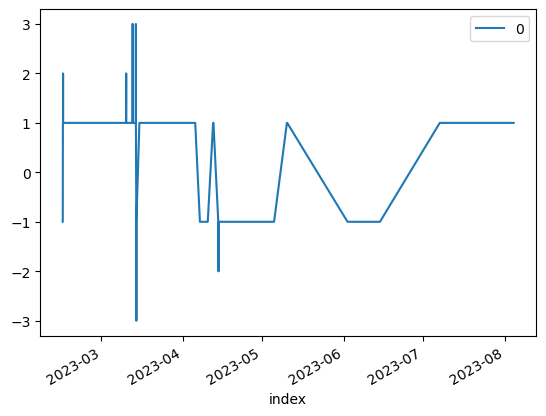

In [427]:
pos=pd.DataFrame(pos, index = longs.index)
pos[pos[0]!=0].plot()

In [74]:
pos=pd.DataFrame(pos)

pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
print("---returns data %s seconds ---" % (time.time() - start_time))
start_time = time.time()
sharpe = np.sqrt(252)*np.mean(ret)/np.std(ret)
print("---sharpe data %s seconds ---" % (time.time() - start_time))
start_time = time.time()

NameError: name 'signal_returns' is not defined

In [70]:
for ticker_ts in tickers:

    #Let's set horizons for holding positions and oscciated returns  
    #This will allow us to see the historic returns using the signal without explicit profit targets
    #From here we can set expectations of profit targets when we do use the signal caveat based off historical values

    horizons = np.linspace(1, 180, 180,dtype = int)#[1,2,3,4,5,10,20]
    #pnl_raw=df[[ticker_ts]].copy().dropna() # to be consumed into the pnl_df
    pnl_raw=df.copy().dropna()
    pnl_df =pd.DataFrame(index =pnl_raw.index )
    #STOP LOSS STEP 1 define dataframe ####################################
    stoploss_df = df.copy()
    
    for horizon in horizons:
        horizon = int(horizon)
        pnl_df["returns_"] = -pnl_raw.diff(-horizon)#.diff(horizon)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [34]:
df['date']=df.index.strftime("%m/%d/%Y")

In [60]:
df

,open,high,low,close,volume,num_trds,value,ticker,date,time
2023-01-30 18:03:00-05:00,9692.0,9692.0,9692.0,9692.0,13,3,1259.960,SFRZ4 Comdty,01/30/2023,18:03:00
2023-01-30 18:04:00-05:00,9691.5,9691.5,9691.5,9691.5,4,3,387.660,SFRZ4 Comdty,01/30/2023,18:04:00
2023-01-30 18:05:00-05:00,9691.5,9691.5,9691.5,9691.5,1,1,96.915,SFRZ4 Comdty,01/30/2023,18:05:00
2023-01-30 18:17:00-05:00,9691.5,9691.5,9691.5,9691.5,2,1,193.830,SFRZ4 Comdty,01/30/2023,18:17:00
2023-01-30 18:22:00-05:00,9691.0,9691.0,9691.0,9691.0,4,1,387.640,SFRZ4 Comdty,01/30/2023,18:22:00
...,...,...,...,...,...,...,...,...,...,...
2023-08-15 14:14:00-04:00,9578.5,9578.5,9578.5,9578.5,82,10,7854.371,SFRZ4 Comdty,08/15/2023,14:14:00
2023-08-15 14:15:00-04:00,9578.5,9578.5,9578.5,9578.5,27,3,2586.195,SFRZ4 Comdty,08/15/2023,14:15:00
2023-08-15 14:16:00-04:00,9578.5,9578.5,9578.0,9578.0,334,23,31990.863,SFRZ4 Comdty,08/15/2023,14:16:00
2023-08-15 14:17:00-04:00,9578.0,9578.0,9578.0,9578.0,680,36,65130.395,SFRZ4 Comdty,08/15/2023,14:17:00


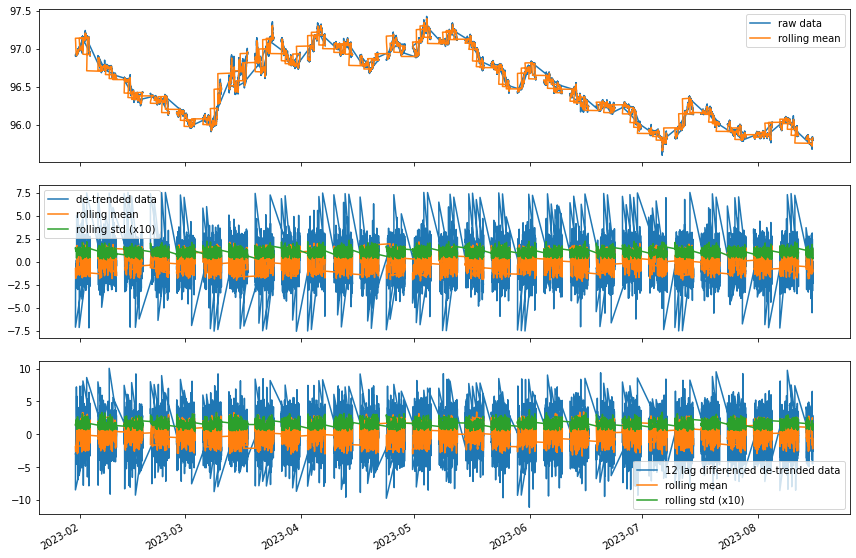

In [15]:

train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
#df['open'].plot(figsize=(12,3));
#plt.title(jobj[0]['title']);

df['z_open'] = (df['open'] - df['open'].rolling(window=60).mean()) / df['open'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_open'] - df['z_open'].shift(60)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['open'], label='raw data')
    ax[0].plot(df['open'].rolling(window=60).mean(), label="rolling mean");
    #ax[0].plot(df['open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_open'], label="de-trended data")
    ax[1].plot(df['z_open'].rolling(window=60).mean(), label="rolling mean");
    ax[1].plot(df['z_open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df['zp_data'], label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_data'].rolling(window=60).mean(), label="rolling mean");
    ax[2].plot(df['zp_data'].rolling(window=60).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df)

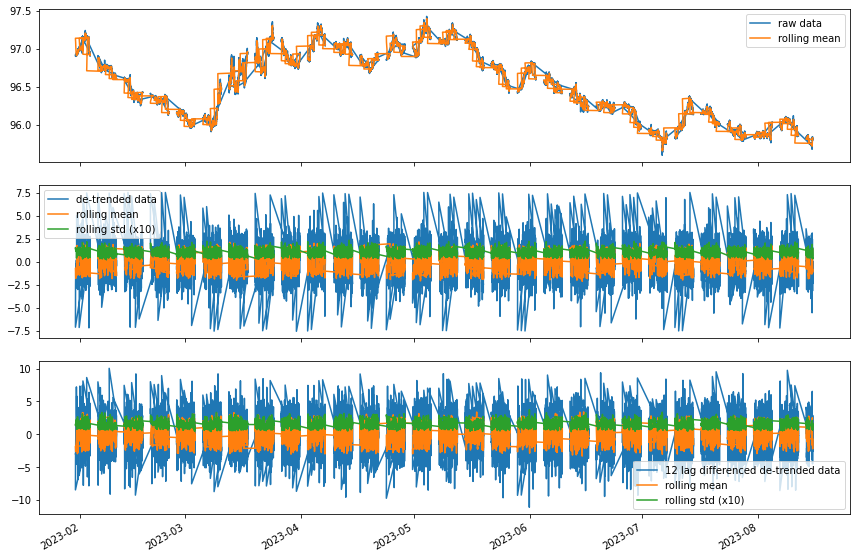

In [7]:
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
#df['open'].plot(figsize=(12,3));
#plt.title(jobj[0]['title']);

df['z_open'] = (df['open'] - df['open'].rolling(window=60).mean()) / df['open'].rolling(window=60).std() # one hour MA
df['zp_data'] = df['z_open'] - df['z_open'].shift(60)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df['open'], label='raw data')
    ax[0].plot(df['open'].rolling(window=60).mean(), label="rolling mean");
    #ax[0].plot(df['open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df['z_open'], label="de-trended data")
    ax[1].plot(df['z_open'].rolling(window=60).mean(), label="rolling mean");
    ax[1].plot(df['z_open'].rolling(window=60).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df['zp_data'], label="12 lag differenced de-trended data")
    ax[2].plot(df['zp_data'].rolling(window=60).mean(), label="rolling mean");
    ax[2].plot(df['zp_data'].rolling(window=60).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df)

In [135]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df['open'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.11f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df['z_open'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.11f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df['zp_data'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.11f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -0.904
P-value = 0.78674337434
Critical values :
	1%: -3.4310725400597795 - The data is not stationary with 99% confidence
	5%: -2.8618593160475885 - The data is not stationary with 95% confidence
	10%: -2.566939966893172 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -13.788
P-value = 0.00000000000
Critical values :
	1%: -3.4310748627134475 - The data is  stationary with 99% confidence
	5%: -2.8618603423853015 - The data is  stationary with 95% confidence
	10%: -2.5669405132181993 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -14.430
P-value = 0.00000000000
Critical values :
	1%: -3.4310823309791743 - The data is  stationary with 99% confidence
	5%: -2.8618636424684114 - The data is  stationary with 95% confidence
	10%: -2.56694226987094 - The data is  stationary with 90% confidence


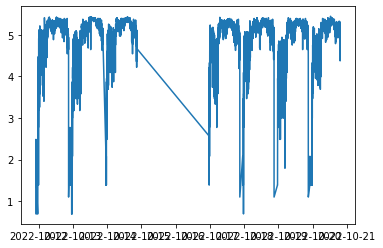

In [138]:
plot(np.log(df['open']))

<AxesSubplot:>

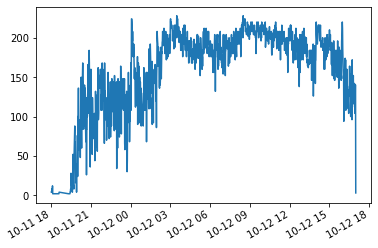

In [141]:
fut['num_trds'].plot()

In [142]:
fut

,open,high,low,close,volume,num_trds,value
2022-10-11 18:01:00-04:00,3.6778,3.6778,3.6770,3.6770,0,4,0.0
2022-10-11 18:02:00-04:00,3.6770,3.6770,3.6770,3.6770,0,4,0.0
2022-10-11 18:03:00-04:00,3.6770,3.6770,3.6770,3.6770,0,8,0.0
2022-10-11 18:04:00-04:00,3.6770,3.6770,3.6770,3.6770,0,4,0.0
2022-10-11 18:05:00-04:00,3.6770,3.6770,3.6770,3.6770,0,4,0.0
...,...,...,...,...,...,...,...
2022-10-12 16:56:00-04:00,3.6361,3.6373,3.6355,3.6372,0,138,0.0
2022-10-12 16:57:00-04:00,3.6371,3.6375,3.6362,3.6367,0,104,0.0
2022-10-12 16:58:00-04:00,3.6367,3.6367,3.6352,3.6358,0,140,0.0
2022-10-12 16:59:00-04:00,3.6358,3.6372,3.6355,3.6370,0,140,0.0


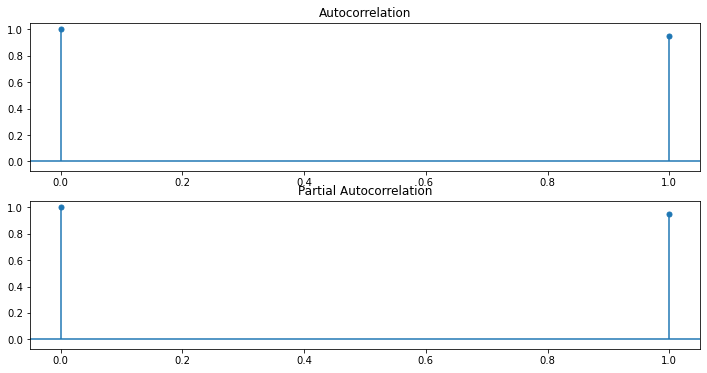

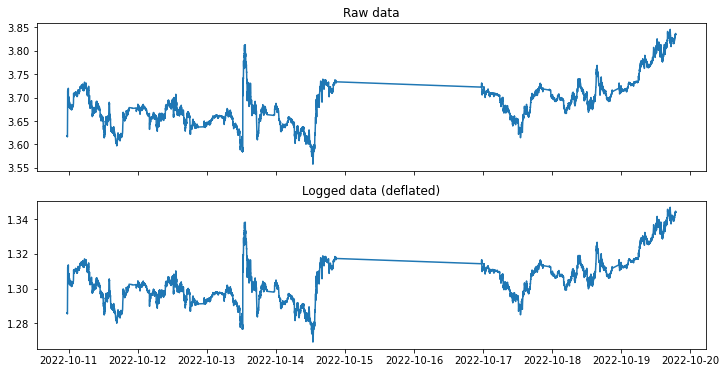

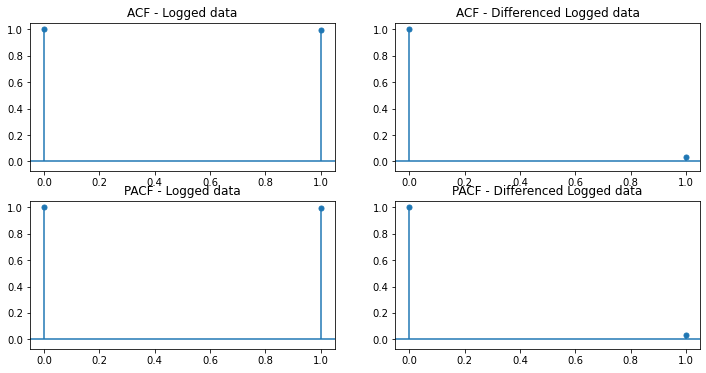

In [129]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
'''
“ — Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
— Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.”
'''


fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df['z_open'].dropna(), ax=ax[0], lags=1)
ax[1] = plot_pacf(df['z_open'].dropna(), ax=ax[1], lags=1)

#test 
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(df['open']);
ax[0].set_title("Raw data");
ax[1].plot(np.log(df['open']));
ax[1].set_title("Logged data (deflated)");
#ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(df['open'])- np.log(df['open']).shift()).dropna()
ax[0, 0] = plot_acf(np.log(df['open']), ax=ax[0, 0], lags=1, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(df['open']), ax=ax[1, 0], lags=1, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=1, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=1, title="PACF - Differenced Logged data")

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequ

                              ARMA Model Results                              
Dep. Variable:                   open   No. Observations:                 9050
Model:                     ARMA(0, 0)   Log Likelihood               26479.960
Method:                           css   S.D. of innovations              0.013
Date:                Wed, 19 Oct 2022   AIC                         -52955.921
Time:                        16:01:55   BIC                         -52941.700
Sample:                             0   HQIC                        -52951.083
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3047      0.000   9567.837      0.000       1.304       1.305
                             ARIMA Model Results                              
Dep. Variable:                 D.open   No. Observat

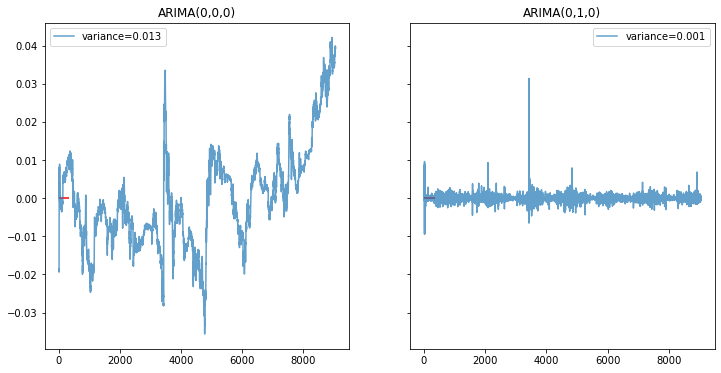

In [126]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df['open']).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df['open']).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequ

                             ARIMA Model Results                              
Dep. Variable:                 D.open   No. Observations:                 9049
Model:                 ARIMA(0, 1, 0)   Log Likelihood               51185.179
Method:                           css   S.D. of innovations              0.001
Date:                Wed, 19 Oct 2022   AIC                        -102366.357
Time:                        16:06:01   BIC                        -102352.136
Sample:                             1   HQIC                       -102361.519
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.437e-06   8.89e-06      0.724      0.469    -1.1e-05    2.39e-05
                             ARIMA Model Results                              
Dep. Variable:                 D.open   No. Observat

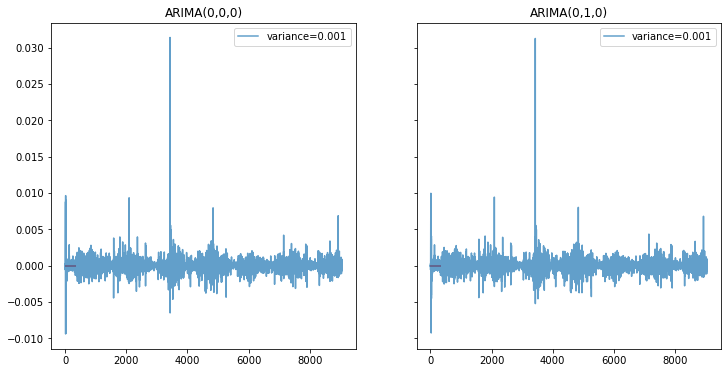

In [128]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df['open']).dropna(), (0, 1, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df['open']).dropna(), (2, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

In [132]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


ModuleNotFoundError: No module named 'pmdarima'

In [131]:
from platform import python_version
python_version() 

'3.8.8'